In [2]:
import sqlite3 as sq
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from bertopic import BERTopic
from transformers import AutoTokenizer, AutoModel, TFAutoModel

import spacy
from tqdm import tqdm

# use displacy to visually show the entities. 
from spacy import displacy


In [2]:
con = sq.connect("NPOPlayer.db")
def run_query(con, table, query):
    cur = con.cursor()
    cur.execute(query)
    results = cur.fetchall()
    return results

def convert_db_table_to_DF(con, table):
    header_query = "SELECT name FROM pragma_table_info('" + table + "') ORDER BY cid;"
    cols_init = run_query(con, table, header_query)
    cols = [cols_init[i][0] for i in range(len(cols_init))]
    content_query = "SELECT * from " + table
    data = run_query(con, table, content_query)
    df = pd.DataFrame(data, columns= cols)
    return df

In [4]:
df = convert_db_table_to_DF(con, "NPOPLAYER")

,mediaID,mainTitle,broadcaster,longSummary,shortSummary,icons,subTitle,thumbnail,kids,shareLink


In [2]:


# load spacy model. Alternatively you can use en_core_web_lg
nlp = spacy.load("nl_core_news_sm")

In [221]:
df_sub = df.copy()
#df_sub = df.sample(6000).copy()

In [3]:
ruler = nlp.add_pipe('entity_ruler', before='ner')

patterns = [
  {"label": "PRODUCT", "pattern": "Wedstrijdanalyse"}
]
ruler.add_patterns(patterns)

In [222]:
def process(x):
  #print(x[0])
  # there are some pesky NaN in the data. Easy but not so elegant way to fix this.
  if (pd.isna(x[0]) == False and x[0] != ""):
    doc = nlp(x[0])
  elif (pd.isna(x[1]) == False and x[1] != ""):
    doc = nlp(x[1])
  else:
    doc = ""
  return doc


tqdm.pandas()
df_sub['plot_entities'] = df_sub[['longSummary', 'shortSummary']].progress_apply(lambda x: process(x), axis = 1)


100%|██████████| 132013/132013 [32:50<00:00, 66.99it/s] 


In [223]:
df_sub

,mediaID,mainTitle,broadcaster,longSummary,shortSummary,icons,subTitle,thumbnail,kids,shareLink,plot_entities
0,POMS_BV_16059067,Kinderen voor Kinderen,BNNVARA,In de achtste aflevering van onze nieuwe dagel...,In de achtste aflevering van onze nieuwe dagel...,,1 apr 2020 10:00 - Seizoen 23 Afl. - 1 april...,https://images.npo.nl/header/2560x1440/1369174...,false,https://www.npostart.nl/POMS_BV_16059067,"(In, de, achtste, aflevering, van, onze, nieuw..."
1,POMS_AT_3975232,Junior Songfestival,AVROTROS,Van alle inschrijvingen zijn er slechts 28 ges...,Van alle inschrijvingen zijn er slechts 28 ges...,leeftijd-al,25 mei 2016 16:02 - Seizoen 12 Afl. - #1 Audi...,https://images.npo.nl/header/2560x1440/752519.jpg,false,https://www.npostart.nl/POMS_AT_3975232,"(Van, alle, inschrijvingen, zijn, er, slechts,..."
2,KN_1685196,Boer zoekt Vrouw,KRO-NCRV,,"Vijf boeren met zeer uiteenlopende karakters, ...",,8 okt 2016 16:00 - Seizoen 10 Afl. 1 - 1. De ...,https://images.npo.nl/header/2560x1440/1074810...,false,https://www.npostart.nl/KN_1685196,"(Vijf, boeren, met, zeer, uiteenlopende, karak..."
3,WO_KN_15405842,Op avontuur met de opa van Tim,KRO-NCRV,,Tim Senders en zijn opa Frits gaan op avontuur...,leeftijd-al,24 apr 2019 15:00 - Seizoen 1 Afl. - #1 De Ca...,https://images.npo.nl/header/2560x1440/1215355...,false,https://www.npostart.nl/WO_KN_15405842,"(Tim, Senders, en, zijn, opa, Frits, gaan, op,..."
4,BNN_101372385,"1 Dorp, 1 Postcode, 43 Miljoen",BNN,Wat gebeurt er met de inwoners van een klein Z...,Wat gebeurt er met de inwoners van een klein Z...,,"2 jan 2015 21:29 - Seizoen 1 Afl. 1 - 1 Dorp,...",https://images.npo.nl/header/2560x1440/557420.jpg,false,https://www.npostart.nl/BNN_101372385,"(Wat, gebeurt, er, met, de, inwoners, van, een..."
...,...,...,...,...,...,...,...,...,...,...,...
132008,WO_POWN_8513746,PowNews Flits,PowNed,"Van vernielingen en diefstal tot aanrandingen,...","Van vernielingen en diefstal tot aanrandingen,...","leeftijd-6,grof_taalgebruik",20 apr 2017 00:00 - Seizoen 8 Afl. - Zwembadt...,https://images.npo.nl/header/2560x1440/890863.jpg,false,https://www.npostart.nl/WO_POWN_8513746,"(Van, vernielingen, en, diefstal, tot, aanrand..."
132009,WO_POWN_4830071,PowNews Flits,PowNed,,,,23 aug 2016 00:00 - Seizoen 7 Afl. - Zwemfees...,,false,https://www.npostart.nl/WO_POWN_4830071,
132010,WO_VPRO_15361112,Schroom,VPRO,Sjezen om je vliegtuig te halen en dan zulke t...,Sjezen om je vliegtuig te halen en dan zulke t...,,10 apr 2019 14:06 - Seizoen 2 Afl. - ZWETEN B...,https://images.npo.nl/header/2560x1440/1210745...,false,https://www.npostart.nl/WO_VPRO_15361112,"(Sjezen, om, je, vliegtuig, te, halen, en, dan..."
132011,WO_POWN_3465954,PowNews Flits,PowNed,,,,12 mrt 2016 19:00 - Seizoen 7 Afl. - Zwijgpli...,,false,https://www.npostart.nl/WO_POWN_3465954,


In [225]:
df_sub.to_csv("NER.csv", sep=";")
# df_sub.to_pickle("NER.pkl")


In [2]:
df_sub = pd.read_csv("NPOPlayer.csv", sep=";")

In [3]:
df_sub = pd.read_pickle("NER.pkl")

In [5]:
df_sub

,mediaID,mainTitle,broadcaster,longSummary,shortSummary,icons,subTitle,thumbnail,kids,shareLink,plot_entities
0,POMS_BV_16059067,Kinderen voor Kinderen,BNNVARA,In de achtste aflevering van onze nieuwe dagel...,In de achtste aflevering van onze nieuwe dagel...,,1 apr 2020 10:00 - Seizoen 23 Afl. - 1 april...,https://images.npo.nl/header/2560x1440/1369174...,false,https://www.npostart.nl/POMS_BV_16059067,"(In, de, achtste, aflevering, van, onze, nieuw..."
1,POMS_AT_3975232,Junior Songfestival,AVROTROS,Van alle inschrijvingen zijn er slechts 28 ges...,Van alle inschrijvingen zijn er slechts 28 ges...,leeftijd-al,25 mei 2016 16:02 - Seizoen 12 Afl. - #1 Audi...,https://images.npo.nl/header/2560x1440/752519.jpg,false,https://www.npostart.nl/POMS_AT_3975232,"(Van, alle, inschrijvingen, zijn, er, slechts,..."
2,KN_1685196,Boer zoekt Vrouw,KRO-NCRV,,"Vijf boeren met zeer uiteenlopende karakters, ...",,8 okt 2016 16:00 - Seizoen 10 Afl. 1 - 1. De ...,https://images.npo.nl/header/2560x1440/1074810...,false,https://www.npostart.nl/KN_1685196,"(Vijf, boeren, met, zeer, uiteenlopende, karak..."
3,WO_KN_15405842,Op avontuur met de opa van Tim,KRO-NCRV,,Tim Senders en zijn opa Frits gaan op avontuur...,leeftijd-al,24 apr 2019 15:00 - Seizoen 1 Afl. - #1 De Ca...,https://images.npo.nl/header/2560x1440/1215355...,false,https://www.npostart.nl/WO_KN_15405842,"(Tim, Senders, en, zijn, opa, Frits, gaan, op,..."
4,BNN_101372385,"1 Dorp, 1 Postcode, 43 Miljoen",BNN,Wat gebeurt er met de inwoners van een klein Z...,Wat gebeurt er met de inwoners van een klein Z...,,"2 jan 2015 21:29 - Seizoen 1 Afl. 1 - 1 Dorp,...",https://images.npo.nl/header/2560x1440/557420.jpg,false,https://www.npostart.nl/BNN_101372385,"(Wat, gebeurt, er, met, de, inwoners, van, een..."
...,...,...,...,...,...,...,...,...,...,...,...
132008,WO_POWN_8513746,PowNews Flits,PowNed,"Van vernielingen en diefstal tot aanrandingen,...","Van vernielingen en diefstal tot aanrandingen,...","leeftijd-6,grof_taalgebruik",20 apr 2017 00:00 - Seizoen 8 Afl. - Zwembadt...,https://images.npo.nl/header/2560x1440/890863.jpg,false,https://www.npostart.nl/WO_POWN_8513746,"(Van, vernielingen, en, diefstal, tot, aanrand..."
132009,WO_POWN_4830071,PowNews Flits,PowNed,,,,23 aug 2016 00:00 - Seizoen 7 Afl. - Zwemfees...,,false,https://www.npostart.nl/WO_POWN_4830071,
132010,WO_VPRO_15361112,Schroom,VPRO,Sjezen om je vliegtuig te halen en dan zulke t...,Sjezen om je vliegtuig te halen en dan zulke t...,,10 apr 2019 14:06 - Seizoen 2 Afl. - ZWETEN B...,https://images.npo.nl/header/2560x1440/1210745...,false,https://www.npostart.nl/WO_VPRO_15361112,"(Sjezen, om, je, vliegtuig, te, halen, en, dan..."
132011,WO_POWN_3465954,PowNews Flits,PowNed,,,,12 mrt 2016 19:00 - Seizoen 7 Afl. - Zwijgpli...,,false,https://www.npostart.nl/WO_POWN_3465954,


In [6]:
from tqdm import tqdm
tqdm.pandas()

In [8]:
def get_events(x):
  events = []
  if x != '':
    for entities in x.ents:
      if entities.label_ == 'EVENT':
        events.append(entities.text)
      elif entities.label_ == 'LAW':
        events.append(entities.text)
      elif entities.label_ == 'LOC':
        events.append(entities.text)
      elif entities.label_ == 'GPE':
        events.append(entities.text)
      elif entities.label_ == 'PERSON':
        events.append(entities.text)
      elif entities.label_ == 'PRODUCT':
        events.append(entities.text)
      elif entities.label_ == 'WORK_OF_ART':
        events.append(entities.text)
  return events

# code goes here
df_sub['tags'] = df_sub['plot_entities'].progress_apply(lambda x: get_events(x))
len(df_sub[df_sub["tags"].str.len() == 0])
#df_sub

100%|██████████| 132013/132013 [00:05<00:00, 23901.57it/s]


35416

In [9]:
media_tag_dict = dict(df_sub[["mediaID", "tags"]].values)

In [10]:
import json

In [12]:
def save_activities():
    with open('miediaID_NERTags.json', 'w') as outfile:
        json.dump(media_tag_dict, outfile)
save_activities()

In [265]:
def jaccard_distance(user_ids_isbn_a, user_ids_isbn_b):
                
    set_isbn_a = set(user_ids_isbn_a)
    set_isbn_b = set(user_ids_isbn_b)
    
    union = set_isbn_a.union(set_isbn_b)
    intersection = set_isbn_a.intersection(set_isbn_b)
        
    return len(intersection) / float(len(union))
# code goes here
def get_jaccard_distances(mediaID):
    tags = media_tag_dict[mediaID]
    distancelist = []
    for key, value in media_tag_dict.items():
        distance = jaccard_distance(tags ,value)
        distancelist.append([key, distance])
        
    return distancelist

def get_recommendation(mediaID, topk = 10):
    broadcastExclude = df_sub.query(f"mediaID == '{mediaID}'")["broadcaster"].values[0]
    temp = (pd.DataFrame(get_jaccard_distances("POW_03470999"), columns=['mediaID','JS']).sort_values(by='JS', ascending=False))
    merged = pd.merge(left=temp, right=df_sub[['mediaID', "tags", 'broadcaster']], left_on='mediaID', right_on="mediaID", how="inner")[['mediaID', 'JS',"tags", "broadcaster"]]
    return merged.query(f"broadcaster != '{broadcastExclude}'").head(topk)



In [268]:
get_recommendation("POW_03470999")

,mediaID,JS,tags,broadcaster
34,WO_NTR_15704461,0.333333,[Noordpool],NTR
35,POW_00572609,0.250000,"[Masha, Noordpool]",VPRO
38,POW_03876966,0.250000,"[Bioloog Midas Dekkers, Noordpool]",MAX
39,VPWON_1276272,0.250000,"[Bernice Notenboom, Noordpool]",EO
42,VPWON_1259794,0.200000,"[Ballonnen, Melktanden, Noordpool]",NTR
43,VPWON_1271751,0.200000,"[Ballonnen, Melktanden, Noordpool]",NTR
44,VPWON_1295403,0.200000,"[Noordpool, Noordpoolbewoners, Kadir van Lohui...",VPRO
45,VPWON_1269119,0.200000,"[Ballonnen, Melktanden, Noordpool]",NTR
46,VPWON_1276271,0.200000,"[Bernice Notenboom, Noordpool, Lukt, Bernice N...",EO
47,VPWON_1264049,0.200000,"[Ballonnen, Melktanden, Noordpool]",NTR


,mediaID,mainTitle,broadcaster,longSummary,shortSummary,icons,subTitle,thumbnail,kids,shareLink,plot_entities,tags


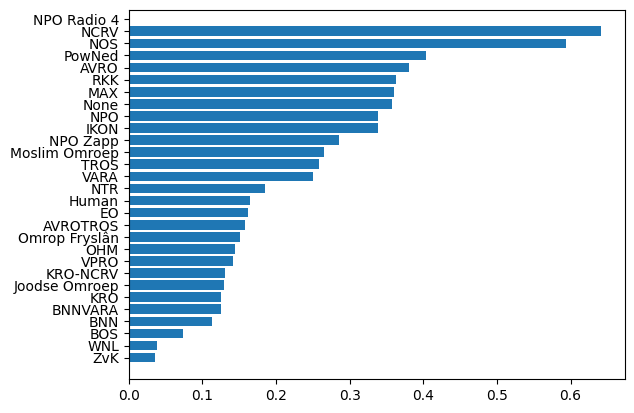

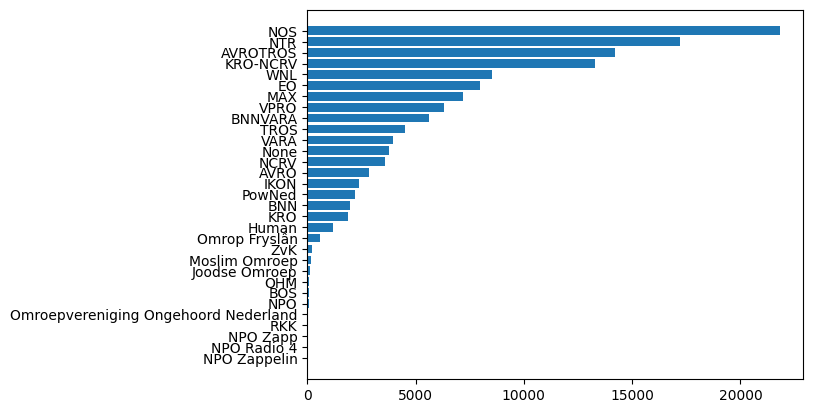

In [269]:
(a:= (df_sub[df_sub["tags"].str.len() == 0]).groupby("broadcaster").count()["mediaID"])
(b:= df_sub.groupby("broadcaster").count()["mediaID"])
frac = (a/b).sort_values(ascending=True)
x = frac.index
y = frac.values
fig, ax = plt.subplots()
ax.barh(x, y)

counts = b.sort_values(ascending=True)
fig, ax = plt.subplots()
ax.barh(counts.index, counts.values)

#plt.bar(x = y,y = x)
#plt.xlim(0,1)


#df_sub.query("tags.str.len() != 0 and longSummary == ''")
df_sub.query("kids == 'true'")

#[df_sub[df_sub["tags"].str.len() != 0]["broadcaster"] == "NOS"]

In [271]:
df_sub["length"] = (df_sub["tags"].apply(lambda x: len(x)))

(0.0, 20.0)

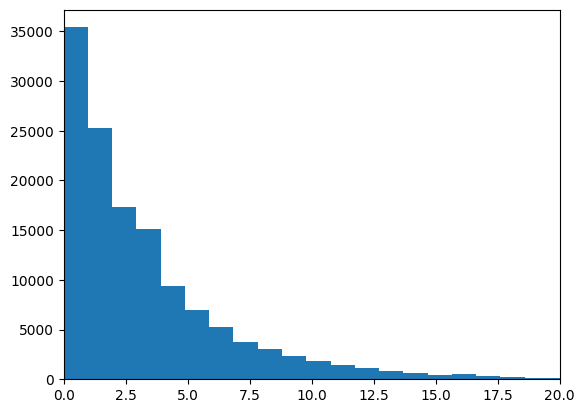

In [274]:
plt.hist(df_sub["length"], bins=140)
plt.xlim(0,20)

In [275]:
con.close()

In [3]:
docs = df_sub["longSummary"].fillna("").values.tolist()

In [4]:
def lowerCase(input: str) -> str:
    return input.lower()

def punctRemove(input: str) -> str:
    return input.translate(str.maketrans('','',string.punctuation))

In [5]:
newdoc = [str(i).lower().translate(str.maketrans('','',string.punctuation)) for i in docs] # Weird format, since pandas give weird doc return


In [6]:
s=set(stopwords.words('dutch'))

def stopWordRemove(input: list[str]) -> list[str]:
    return list(filter(lambda x: not x in s, input))

def stopWords(inputdoc: list[str]):
    return (" ".join(stopWordRemove((inputdoc).split(" "))))

result = [0 for i in range(len(docs))]
for i, doc in enumerate(tqdm(docs)):
    result[i] = stopWords(doc)


100%|██████████| 132013/132013 [00:01<00:00, 78453.70it/s]


In [8]:
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
model = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")
#model = TFAutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")

Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(ngram_range=(1,2), min_df=2)

In [11]:
topic_model = BERTopic(language="dutch", calculate_probabilities=True, verbose=True)#, embedding_model=model, vectorizer_model= vectorizer_model)
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/4126 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [50]:
topic_model.get_topic_info()

,Topic,Count,Name
0,0,711,0_de_en_een_van
1,1,191,1_tel_graaf_liveverslag_
2,2,55,2_van_de_en_het
3,3,32,3_nieuws_laatste_en_weersverwachting
4,4,11,4_fenna_zappie_ze_haar


In [9]:
from sklearn.datasets import fetch_20newsgroups

docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']


KeyboardInterrupt: 

In [ ]:
docs